# Impact of changing damage function location on forecast value

In [1]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('..')
from ruv.relative_utility_value import relative_utility_value
from ruv.damage_functions import logistic
from ruv.economic_models import cost_loss, cost_loss_analytical_spend
from ruv.utility_functions import cara
from ruv.decision_rules import optimise_over_forecast_distribution
from ruv.helpers import risk_aversion_coef_to_risk_premium, risk_premium_to_risk_aversion_coef

# Load example forecast dataset

In [3]:
# Steamflow at Biggara in the Murray catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE

# load forecasts (and obs) and climatology
data = pd.read_csv('example_data/401012-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')
clim = pd.read_csv('example_data/401012-climatology.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')

# convert runoff to cumecs
data *= 1165 / 86.4
clim *= 1165 / 86.4

# filter to the first week of each month
data = data[(data.index.day >= 1) & (data.index.day <= 7)]
clim = clim[(clim.index.day >= 1) & (clim.index.day <= 7)]

# fetch the obs and forecast ensemble
obs = data['obs']
fcst = data[[col for col in data.columns if col.startswith('ens-')]]
clim = clim[[col for col in clim.columns if col.startswith('ens-')]]

# clean climatology of NA ensemble members from ragged 14-day moving average climatology dataset
clim_arr = clim.to_numpy()
sorted_arr = np.take_along_axis(clim_arr, np.argsort(np.isnan(clim_arr), axis=1, kind='stable'), axis=1)
max_size_ens = np.count_nonzero(~np.isnan(clim_arr), axis=1).min()
ens = sorted_arr[:, :max_size_ens]
clim = pd.DataFrame(ens, index=clim.index, columns=[f"ens-{i+1}" for i in range(max_size_ens)])

# RUV library expects numpy arrays
obs = obs.values
fcst = fcst.values
clim = clim.values

print(obs.shape, fcst.shape, clim.shape)

(1932,) (1932, 100) (1932, 484)


# Experiment setup

In [4]:
parallel_nodes = 2

# define range of alphas we will calculate over
alpha_step = 0.05
alphas = np.arange(alpha_step, 1, alpha_step)
select_alphas = [0.1, 0.5, 0.9]

# define the thresholds we will move the damage function through 
threshold_step = 10
damage_function_thresholds = np.arange(0, np.nanmax(obs) * 1.3, threshold_step)
select_damage_function_thresholds = [50, 100, 150]

# calculate adjust the risk aversion coefficient according to the max damages
target_unity_risk_aversion = 0.15
max_damages = 10000
target_risk_premium = risk_aversion_coef_to_risk_premium(target_unity_risk_aversion, 1)
adjusted_risk_aversion = risk_premium_to_risk_aversion_coef(target_risk_premium, max_damages)

# use 14-day moving average climatology as reference
ref = clim

C:\Users\me\work\research\software\relative-utility-value\ruv\helpers.py:64: RuntimeWarning: overflow encountered in exp
  return np.log(0.5 * (np.exp(-A * gamble_size) + np.exp(A * gamble_size))) / (A * gamble_size) - risk_premium


# Value diagram for three damage functions

## Define decision context

In [5]:
decision_context = {
    'utility_function': [cara, {'A': adjusted_risk_aversion}],
    'decision_rule': [optimise_over_forecast_distribution, None],
    'decision_thresholds': None,
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'damage_function': [logistic, {'k': 0.2, 'A': max_damages, 'threshold': None}]
}

## Calculate RUV

In [6]:
results = pd.DataFrame(index=alphas, columns=select_damage_function_thresholds)
for damage_function_threshold in select_damage_function_thresholds:
    print('Calculating RUV for damage function threshold %.2f' % damage_function_threshold)
    decision_context['damage_function'][1]['threshold'] = damage_function_threshold
    results[damage_function_threshold] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']    

Calculating RUV for damage function threshold 50.00
Calculating RUV for damage function threshold 100.00
Calculating RUV for damage function threshold 150.00


## Plot results

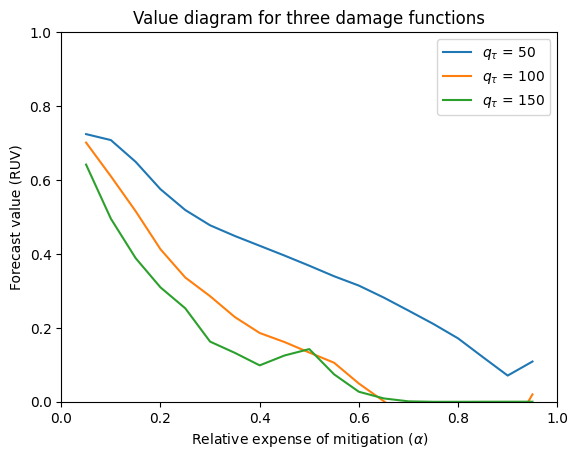

In [7]:
for damage_function_threshold in select_damage_function_thresholds:
    results[damage_function_threshold].plot(label=r'$q_\tau$ = %.0f' % damage_function_threshold)
plt.title('Value diagram for three damage functions')
plt.xlabel(r'Relative expense of mitigation ($\alpha$)')
plt.ylabel('Forecast value (RUV)')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()

# Value for damage functions of varying location

## Define decision context

In [8]:
decision_context = {
    'utility_function': [cara, {'A': adjusted_risk_aversion}],
    'decision_rule': [optimise_over_forecast_distribution, None],
    'decision_thresholds': None,
    'economic_model': [cost_loss, cost_loss_analytical_spend, select_alphas],
    'damage_function': [logistic, {'k': 0.2, 'A': max_damages, 'threshold': None}]
}

## Calculate RUV

In [9]:
results = pd.DataFrame(index=damage_function_thresholds, columns=select_alphas)
for damage_function_threshold in damage_function_thresholds:
    print('Calculating RUV for damage function threshold %.2f' % damage_function_threshold)
    decision_context['damage_function'][1]['threshold'] = damage_function_threshold
    results.loc[damage_function_threshold] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

Calculating RUV for damage function threshold 0.00
Calculating RUV for damage function threshold 10.00
Calculating RUV for damage function threshold 20.00
Calculating RUV for damage function threshold 30.00
Calculating RUV for damage function threshold 40.00
Calculating RUV for damage function threshold 50.00
Calculating RUV for damage function threshold 60.00
Calculating RUV for damage function threshold 70.00
Calculating RUV for damage function threshold 80.00
Calculating RUV for damage function threshold 90.00
Calculating RUV for damage function threshold 100.00
Calculating RUV for damage function threshold 110.00
Calculating RUV for damage function threshold 120.00
Calculating RUV for damage function threshold 130.00
Calculating RUV for damage function threshold 140.00
Calculating RUV for damage function threshold 150.00
Calculating RUV for damage function threshold 160.00
Calculating RUV for damage function threshold 170.00
Calculating RUV for damage function threshold 180.00
Calc

## Plot results

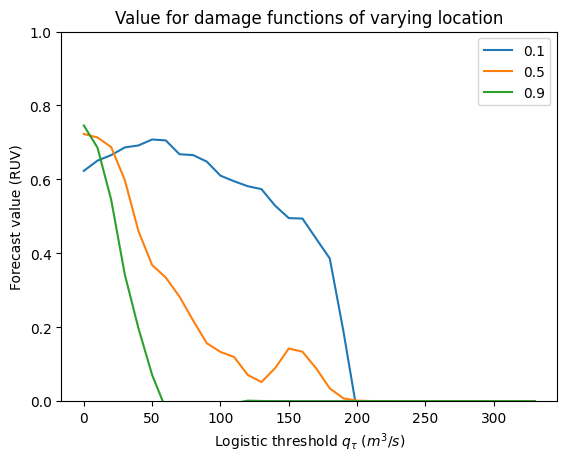

In [10]:
results.plot()
plt.title('Value for damage functions of varying location')
plt.xlabel(r'Logistic threshold $q_\tau$ ($m^3/s$)')
plt.ylabel('Forecast value (RUV)')
plt.ylim(0, 1)
plt.legend()